In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
import pywt
import heartpy as hp
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt, resample
from scipy import signal
from data_subplot import data_subplot
from scipy.stats import pearsonr
from detect_body_movements import detect_patterns
from band_pass_filtering import band_pass_filtering
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
import math
from remove_nonLinear_trend import remove_nonLinear_trend
from compute_vitals import vitals

%matplotlib inline

SYNCHRONIZATION FUNCTION


In [2]:


# SYNC
def build_bcg_df(bcg_values, initial_timestamp, fs):
    """
    Constructs a BCG DataFrame from raw values, initial timestamp, and sampling rate.
    
    Args:
        bcg_values: List of BCG signal values (e.g., [-86, -90, -91, -86])
        initial_timestamp: Timestamp of first sample (epoch ms or datetime string)
        fs: Sampling frequency in Hz
        
    Returns:
        pd.DataFrame with columns: ['Timestamp', 'BCG', 'Time']
    """
    # Convert timestamp to datetime if it's a string
    if isinstance(initial_timestamp, str):
        initial_timestamp = pd.to_datetime(initial_timestamp)
    elif isinstance(initial_timestamp, (int, float)):
        initial_timestamp = pd.to_datetime(initial_timestamp, unit='ms')
    
    # Calculate time intervals
    period = 1 / fs
    timestamps = [initial_timestamp + pd.Timedelta(seconds=i*period) 
                 for i in range(len(bcg_values))]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'BCG': bcg_values
    })
    
    # Add human-readable time
    df['Time'] = df['Timestamp'].dt.strftime('%H:%M:%S.%f')
    
    return df




def synchronize_bcg_and_hr(df_bcg_raw, df_hr_raw):
    """
    Builds and synchronizes BCG and HR DataFrames starting from the first common time.
    
    Args:
        df_bcg_raw: Raw BCG DataFrame from CSV. Must contain 'BCG', 'Timestamp', and 'fs' columns.
        df_hr_raw: Raw HR DataFrame from CSV. Must contain 'Timestamp' column in datetime-compatible format.
    
    Returns:
        bcg_aligned, hr_aligned: Time-synchronized DataFrames
    """
        # Parse BCG values and metadata
    bcg_values = df_bcg_raw['BCG'].tolist()
    initial_timestamp = pd.to_datetime(df_bcg_raw.loc[0, 'Timestamp'], unit='ms')
    fs = float(df_bcg_raw.loc[0, 'fs'])

    # Build BCG DataFrame
    df_bcg = build_bcg_df(bcg_values, initial_timestamp, fs)

    # Parse HR timestamps
    df_hr_raw['Timestamp'] = pd.to_datetime(df_hr_raw['Timestamp'])

    # Find common time range
    start_time = max(df_bcg['Timestamp'].min(), df_hr_raw['Timestamp'].min())
    end_time = min(df_bcg['Timestamp'].max(), df_hr_raw['Timestamp'].max())

    # Trim both DataFrames to common range
    bcg_aligned = df_bcg[(df_bcg['Timestamp'] >= start_time) & (df_bcg['Timestamp'] <= end_time)].copy()
    hr_aligned = df_hr_raw[(df_hr_raw['Timestamp'] >= start_time) & (df_hr_raw['Timestamp'] <= end_time)].copy()

    # Reset index
    bcg_aligned.reset_index(drop=True, inplace=True)
    hr_aligned.reset_index(drop=True, inplace=True)

    return bcg_aligned, hr_aligned






DATA SAMPLE LOADING

In [3]:

#read csv files
df_bcg= pd.read_csv('sample/03_20231105_BCG.csv')        #### n4 &
df_heart=pd.read_csv("sample/03_20231105_RR.csv")   #### 1 second one

# step 1 :Synchronize BCG and HR DataFrames from the first common time
bcg_sync, hr_sync = synchronize_bcg_and_hr(df_bcg, df_heart)

print("Time synchronized BCG DataFrame:")
print(bcg_sync.head())
print("\nTime synchronized Heart Rate DataFrame:")
print(hr_sync.head())


Time synchronized BCG DataFrame:
                      Timestamp  BCG             Time
0 2023-11-05 00:03:48.005714285  -60  00:03:48.005714
1 2023-11-05 00:03:48.012857142  -79  00:03:48.012857
2 2023-11-05 00:03:48.019999999  -77  00:03:48.019999
3 2023-11-05 00:03:48.027142857  -80  00:03:48.027142
4 2023-11-05 00:03:48.034285714  -58  00:03:48.034285

Time synchronized Heart Rate DataFrame:
            Timestamp  Heart Rate  RR Interval in seconds
0 2023-11-05 00:03:48          84                   0.813
1 2023-11-05 00:03:49          83                   0.876
2 2023-11-05 00:03:50          81                   0.745
3 2023-11-05 00:03:50          81                   0.706
4 2023-11-05 00:03:51          81                   0.722


SET TIMESTAMP AS INDEX IN REFERENCE HR

In [4]:
hr_sync['Timestamp'] = pd.to_datetime(hr_sync['Timestamp'])

# Set Timestamp as the index
hr_sync.set_index('Timestamp', inplace=True)


RESAMPLING TO 50 HZ

In [5]:
# resample bcg to 50 hz 
bcg_sync.set_index('Timestamp', inplace=True)

# Original sampling rate (140 Hz)
fs_original = 140  
# Target sampling rate (50 Hz)
fs_target = 50  

# Calculate resampling factor
resample_factor = fs_target / fs_original

# Number of samples in resampled signal
num_samples = int(len(bcg_sync) * resample_factor)

# Resample the BCG signal using Fourier method (preserves timing information)
resampled_bcg = signal.resample(bcg_sync['BCG'], num_samples)

# Create new timestamps for the resampled data
start_time = bcg_sync.index[0]
end_time = bcg_sync.index[-1]
new_timestamps = pd.date_range(start=start_time, end=end_time, periods=num_samples)

# Create new DataFrame with resampled data
resampled_df = pd.DataFrame({
    'BCG': resampled_bcg,
    'Time': new_timestamps.time
}, index=new_timestamps)

# Reset index if you want Timestamp as a column again
resampled_df.reset_index(inplace=True)
resampled_df.rename(columns={'index': 'Timestamp'}, inplace=True)

print(resampled_df.head())

                      Timestamp         BCG             Time
0 2023-11-05 00:03:48.005714285 -123.144952  00:03:48.005714
1 2023-11-05 00:03:48.025714400  -47.512363  00:03:48.025714
2 2023-11-05 00:03:48.045714516  -75.158862  00:03:48.045714
3 2023-11-05 00:03:48.065714632 -206.820384  00:03:48.065714
4 2023-11-05 00:03:48.085714748  -22.344240  00:03:48.085714


NUMBER OF WINDOWS

In [6]:
total =len(resampled_df)/500
total = int(total)
print(total)

517


GENERATION OF VALID SLEEP SIGNAL WINDOWS

Data stream length: 258632


/tmp/ipykernel_29319/598734467.py:3: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**6 # convert to milliseconds


Bad windows: [  6   7  89  90 103 122 123 166 167 171 195 196 226 227 276 277 318 320
 321 323 324 325 327 328 334 335 342 348 349 351 360 363 364 365 376 377
 378 379 380 384 392 398 400 402 403 405 426 427 428 430 431 433 435 441
 443 451 457 472 489 510 511]


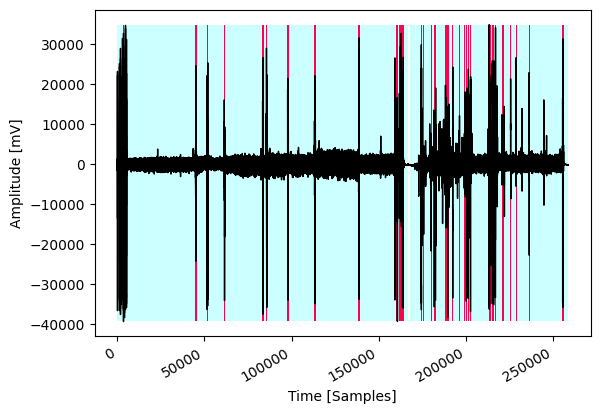

In [7]:
bcg = resampled_df
start_point, end_point, window_shift, fs = 0, 500, 500, 50
bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**6 # convert to milliseconds
utc_time = bcg['epoch']
data_stream = bcg['BCG']
print("Data stream length:", len(data_stream))
data_stream, utc_time, bad_windows  = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
print("Bad windows:", bad_windows)

FILTERING ALONG WITH S4 DECOMPOSITION FOR BETTER J PEAKS DETECTION

Wavelet Cycle Length: 258570


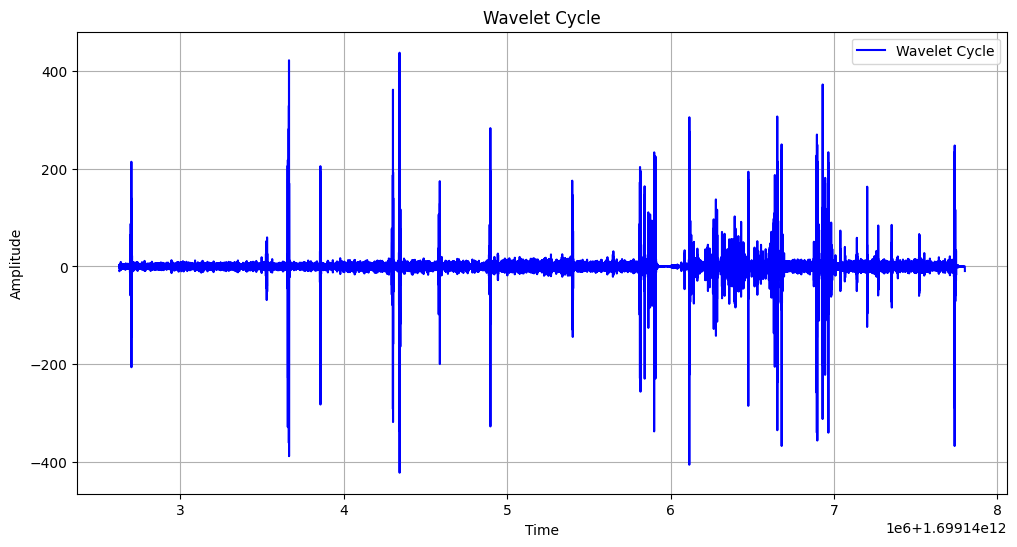

In [8]:
movement = band_pass_filtering(data_stream, fs, "bcg")
breathing = band_pass_filtering(data_stream, fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]
print("Wavelet Cycle Length:", len(wavelet_cycle))
# plot the wavelet cycle
plt.figure(figsize=(12, 6))
plt.plot(utc_time, wavelet_cycle, label='Wavelet Cycle', color='blue')
plt.title('Wavelet Cycle')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

COMPUTING HR FOR EACH WINDOW

In [9]:
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time.values, mpd=1, plot=0)  # utc_time.values in seconds 


In [10]:
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))
print('length of pulse : ', int(len(beats)))

Minimum pulse :  59.0
Maximum pulse :  101.0
Average pulse :  80.0
length of pulse :  517


GETTING REFERENCE HR FOR EACH VALID WINDOW

In [11]:
hr_sync.index 

DatetimeIndex(['2023-11-05 00:03:48', '2023-11-05 00:03:49',
               '2023-11-05 00:03:50', '2023-11-05 00:03:50',
               '2023-11-05 00:03:51', '2023-11-05 00:03:52',
               '2023-11-05 00:03:53', '2023-11-05 00:03:54',
               '2023-11-05 00:03:54', '2023-11-05 00:03:55',
               ...
               '2023-11-05 01:29:44', '2023-11-05 01:29:44',
               '2023-11-05 01:29:45', '2023-11-05 01:29:46',
               '2023-11-05 01:29:47', '2023-11-05 01:29:48',
               '2023-11-05 01:29:48', '2023-11-05 01:29:59',
               '2023-11-05 01:29:59', '2023-11-05 01:30:00'],
              dtype='datetime64[ns]', name='Timestamp', length=6459, freq=None)

In [12]:
hr_sync.index = pd.to_datetime(hr_sync.index)

# Resample into non-overlapping 10-second windows and compute mean HR
mean_hr_df = hr_sync.resample('10S').mean(numeric_only=True).dropna().reset_index()

# Select and rename columns
mean_hr_df = mean_hr_df[['Timestamp', 'Heart Rate']].rename(
    columns={'Timestamp': 'Window Start', 'Heart Rate': 'Mean HR'}
)
mean_hr_df

/tmp/ipykernel_29319/3326357812.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  mean_hr_df = hr_sync.resample('10S').mean(numeric_only=True).dropna().reset_index()


,Window Start,Mean HR
0,2023-11-05 00:03:40,83.500000
1,2023-11-05 00:03:50,79.923077
2,2023-11-05 00:04:00,78.384615
3,2023-11-05 00:04:10,79.785714
4,2023-11-05 00:04:20,80.846154
...,...,...
509,2023-11-05 01:29:20,78.000000
510,2023-11-05 01:29:30,78.000000
511,2023-11-05 01:29:40,78.250000
512,2023-11-05 01:29:50,76.000000


ELIMINATING BAD WINDOWS (NO SLEEP AND MOVEMENT)

In [13]:
filtered_array = np.delete(beats, bad_windows, axis=0)
len(filtered_array)
filtered_array

array([ 62.37,  61.73,  84.78,  67.26,  80.89,  82.63,  79.47,  94.59,
        82.63,  82.98,  79.14,  86.78,  86.96,  82.57,  79.92,  67.57,
        86.28,  69.47,  87.44,  81.59,  77.41,  93.56,  95.74,  79.12,
        93.13,  94.34,  89.55,  92.11,  77.09,  73.01,  78.95,  77.25,
        71.27,  72.05,  79.12,  72.53,  92.4 ,  67.87,  77.42,  87.5 ,
        79.3 ,  92.11,  86.86,  92.78,  81.08,  89.74,  74.23,  82.  ,
        76.6 ,  73.99,  84.78,  83.16,  83.33,  82.28,  79.99,  81.63,
        85.71,  74.53,  86.47,  84.78,  91.11,  75.  ,  83.87,  82.11,
        81.82,  86.78,  86.28,  78.6 ,  91.7 ,  81.63,  76.21,  86.06,
        91.98,  71.43,  90.52,  76.04,  82.28,  87.5 ,  75.31,  83.33,
        72.53,  91.5 ,  76.92,  83.69,  84.97,  80.36,  88.64,  79.3 ,
        97.76,  82.95,  88.79, 101.48,  74.69,  80.72,  81.08,  78.95,
        79.65,  82.28,  82.19,  77.75,  88.44,  95.54,  82.45,  82.37,
        85.92,  86.09,  87.14,  90.13,  83.51,  89.45,  84.6 ,  86.54,
      

In [14]:
# drop from beats and mean_hr_df the indices in bad windows
existing_bad_windows = [idx for idx in bad_windows if idx in mean_hr_df.index]
filtered_df = mean_hr_df.drop(index=existing_bad_windows)
# same number of windows
filtered_df

,Window Start,Mean HR
0,2023-11-05 00:03:40,83.500000
1,2023-11-05 00:03:50,79.923077
2,2023-11-05 00:04:00,78.384615
3,2023-11-05 00:04:10,79.785714
4,2023-11-05 00:04:20,80.846154
...,...,...
507,2023-11-05 01:29:00,75.769231
508,2023-11-05 01:29:10,77.307692
509,2023-11-05 01:29:20,78.000000
512,2023-11-05 01:29:50,76.000000


ERROR CALCULATION

In [15]:
# error calculation
# error calculation
y_true = filtered_df['Mean HR'].values
y_pred = filtered_array
min_len = min(len(y_true), len(y_pred))
# Trim both to the same length from the end
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]
valid_indices = np.abs(y_true) > 1e-2
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]
# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_true - y_pred))

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

# Mean Absolute Percentage Error (MAPE)
# Add small epsilon to avoid division by zero
epsilon = 1e-10
mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")


MAE: 6.918
RMSE: 9.056
MAPE: 8.45%


Pearson Correlation plot

Pearson Correlation: -0.0020


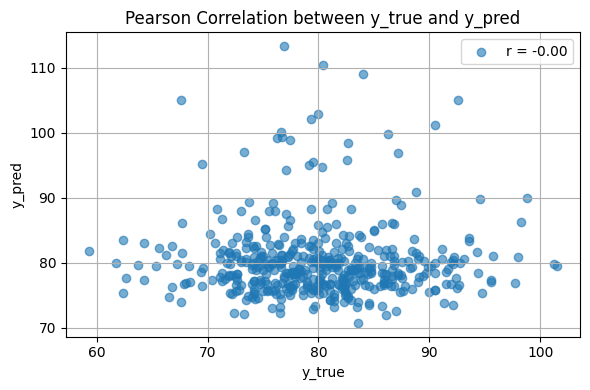

In [16]:

# Compute Pearson correlation
corr, _ = pearsonr(y_true, y_pred)
print(f"Pearson Correlation: {corr:.4f}")

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, y_true, alpha=0.6, label=f"r = {corr:.2f}")
plt.title("Pearson Correlation between y_true and y_pred")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Bland-Altman Plot

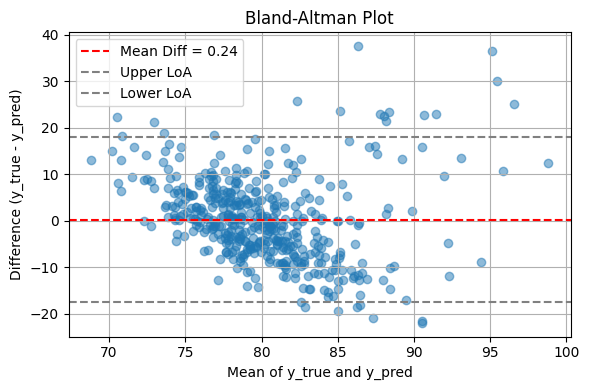

In [17]:

# Compute average and difference
avg = (y_true + y_pred) / 2
diff = y_true - y_pred
mean_diff = np.mean(diff)
std_diff = np.std(diff)

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(avg, diff, alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff = {mean_diff:.2f}')
plt.axhline(mean_diff + 1.96*std_diff, color='gray', linestyle='--', label='Upper LoA') # levels of agreement calculation 1.96 for 95% confidence interval
plt.axhline(mean_diff - 1.96*std_diff, color='gray', linestyle='--', label='Lower LoA')
plt.title('Bland-Altman Plot')
plt.xlabel('Mean of y_true and y_pred')
plt.ylabel('Difference (y_true - y_pred)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Analysis  mean diff close to 0, std diff small, so good agreement
# disagreement at high values of y_true and y_pred